In [3]:
import numpy as np
import os
from pathlib import Path

def read_camels_params():
    """
    Read CosmoAstro_params.txt files from CAMELS IllustrisTNG simulation
    and create a 1024x35 matrix.
    
    Returns:
        numpy.ndarray: 1024x35 matrix where each row corresponds to one simulation
    """
    base_path = "/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35"
    
    # Initialize the matrix
    params_matrix = np.zeros((1024, 35))
    
    # Track which files were successfully read
    successful_reads = []
    failed_reads = []
    
    for i in range(1024):
        file_path = Path(base_path) / f"SB35_{i}" / "CosmoAstro_params.txt"
        
        try:
            # Read the parameter file
            if file_path.exists():
                params = np.loadtxt(file_path)
                
                # Check if we have exactly 35 parameters
                if len(params) == 35:
                    params_matrix[i, :] = params
                    successful_reads.append(i)
                else:
                    print(f"Warning: File {file_path} has {len(params)} parameters, expected 35")
                    failed_reads.append(i)
            else:
                print(f"Warning: File {file_path} does not exist")
                failed_reads.append(i)
                
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            failed_reads.append(i)
    
    print(f"Successfully read {len(successful_reads)} files")
    print(f"Failed to read {len(failed_reads)} files")
    
    if failed_reads:
        print(f"Failed indices: {failed_reads[:10]}{'...' if len(failed_reads) > 10 else ''}")
    
    return params_matrix

def save_params_matrix(params_matrix, output_file="camels_params_matrix.npy"):
    """
    Save the parameters matrix to a file.
    
    Args:
        params_matrix (numpy.ndarray): The 1024x35 parameter matrix
        output_file (str): Output filename
    """
    np.save(output_file, params_matrix)
    print(f"Saved parameter matrix to {output_file}")
    print(f"Matrix shape: {params_matrix.shape}")

def save():
    """Main function to read files and save matrix."""
    print("Reading CAMELS CosmoAstro parameter files...")
    
    # Read all parameter files
    params_matrix = read_camels_params()
    
    # Save the matrix
    save_params_matrix(params_matrix)
    
    # Print some basic statistics
    print(f"\nMatrix statistics:")
    print(f"Shape: {params_matrix.shape}")
    print(f"Non-zero rows: {np.count_nonzero(np.any(params_matrix, axis=1))}")
    print(f"Min value: {np.min(params_matrix):.6f}")
    print(f"Max value: {np.max(params_matrix):.6f}")
    
    # Optionally save as text file as well
    np.savetxt("camels_params_matrix.txt", params_matrix, 
               fmt='%.6e', delimiter='\t',
               header="CAMELS CosmoAstro parameters matrix (1024 simulations x 35 parameters)")
    print("Also saved as camels_params_matrix.txt")


In [4]:
def filter_high_value_simulations(params_matrix, columns=[0, 1, 6, 29, 31], threshold_percentile=99.99):
    """
    Filter simulations with higher values in specified columns.
    
    Args:
        params_matrix (numpy.ndarray): The parameter matrix
        columns (list): Column indices to filter on
        threshold_percentile (float): Percentile threshold for "high" values
    
    Returns:
        dict: Dictionary with filtering results
    """
    results = {}
    
    print(f"\nFiltering simulations with high values in columns {columns}")
    print(f"Using {threshold_percentile}th percentile as threshold")
    
    for col in columns:
        # Calculate threshold for this column
        threshold = np.percentile(params_matrix[:, col], threshold_percentile)
        
        # Find simulations above threshold
        high_value_mask = params_matrix[:, col] > threshold
        high_value_indices = np.where(high_value_mask)[0]
        
        results[col] = {
            'threshold': threshold,
            'simulation_indices': high_value_indices,
            'count': len(high_value_indices),
        }
        75
        print(f"\nColumn {col}:")
        print(f"  Threshold (>{threshold_percentile}th percentile): {threshold:.6f}")
        print(f"  High-value simulations: {len(high_value_indices)}")
        print(f"  Simulation indices: {high_value_indices[:20]}{'...' if len(high_value_indices) > 20 else ''}")
    
    # Find simulations that are high in ALL specified columns
    all_high_mask = np.ones(params_matrix.shape[0], dtype=bool)
    for col in columns:
        threshold = np.percentile(params_matrix[:, col], threshold_percentile)
        all_high_mask &= (params_matrix[:, col] > threshold)
    
    all_high_indices = np.where(all_high_mask)[0]
    
    print(f"\nSimulations high in ALL columns {columns}:")
    print(f"  Count: {len(all_high_indices)}")
    print(f"  Indices: {all_high_indices}")
    
    results['all_high'] = {
        'simulation_indices': all_high_indices,
        'count': len(all_high_indices)
    }
    
    return results

def filter_low_value_simulations(params_matrix, columns=[0, 1, 6, 29, 31], threshold_percentile=0.01):
    results = {}
    
    print(f"\nFiltering simulations with low values in columns {columns}")
    print(f"Using {threshold_percentile}th percentile as threshold")
    
    for col in columns:
        # Calculate threshold for this column
        threshold = np.percentile(params_matrix[:, col], threshold_percentile)
        
        # Find simulations below threshold
        low_value_mask = params_matrix[:, col] < threshold
        low_value_indices = np.where(low_value_mask)[0]
        
        results[col] = {
            'threshold': threshold,
            'simulation_indices': low_value_indices,
            'count': len(low_value_indices),
            'values': params_matrix[low_value_indices, col]
        }
        
        print(f"\nColumn {col}:")
        print(f"  Threshold (<{threshold_percentile}th percentile): {threshold:.6f}")
        print(f"  Low-value simulations: {len(low_value_indices)}")
        print(f"  Simulation indices: {low_value_indices[:20]}{'...' if len(low_value_indices) > 20 else ''}")
    
    # Find simulations that are low in ALL specified columns
    all_low_mask = np.ones(params_matrix.shape[0], dtype=bool)
    for col in columns:
        threshold = np.percentile(params_matrix[:, col], threshold_percentile)
        all_low_mask &= (params_matrix[:, col] < threshold)
    
    all_low_indices = np.where(all_low_mask)[0]
    
    print(f"\nSimulations low in ALL columns {columns}:")
    print(f"  Count: {len(all_low_indices)}")
    print(f"  Indices: {all_low_indices}")
    
    results['all_low'] = {
        'simulation_indices': all_low_indices,
        'count': len(all_low_indices)
    }
    
    return results

In [5]:
params_matrix = np.load("camels_params_matrix.npy")
results_high = filter_high_value_simulations(params_matrix)
results_low = filter_low_value_simulations(params_matrix)


Filtering simulations with high values in columns [0, 1, 6, 29, 31]
Using 99.99th percentile as threshold

Column 0:
  Threshold (>99.99th percentile): 0.499617
  High-value simulations: 1
  Simulation indices: [128]

Column 1:
  Threshold (>99.99th percentile): 0.999787
  High-value simulations: 1
  Simulation indices: [610]

Column 6:
  Threshold (>99.99th percentile): 0.068990
  High-value simulations: 1
  Simulation indices: [758]

Column 29:
  Threshold (>99.99th percentile): -0.002777
  High-value simulations: 1
  Simulation indices: [1007]

Column 31:
  Threshold (>99.99th percentile): -0.000559
  High-value simulations: 1
  Simulation indices: [182]

Simulations high in ALL columns [0, 1, 6, 29, 31]:
  Count: 0
  Indices: []

Filtering simulations with low values in columns [0, 1, 6, 29, 31]
Using 0.01th percentile as threshold

Column 0:
  Threshold (<0.01th percentile): 0.100168
  Low-value simulations: 1
  Simulation indices: [777]

Column 1:
  Threshold (<0.01th percentile

In [11]:
def uniform_sparse_sampling(params_matrix, train_fraction=0.2, method='random', random_seed=42):
    """
    Sparsely and uniformly sample training data from the parameter matrix.
    
    Args:
        params_matrix (numpy.ndarray): The parameter matrix (1024, 35)
        train_fraction (float): Fraction of data to use for training (default 0.2 = 20%)
        method (str): Sampling method - 'random', 'systematic', or 'stratified'
        random_seed (int): Random seed for reproducibility
    
    Returns:
        dict: Dictionary containing train/test indices and matrices
    """
    np.random.seed(random_seed)
    n_samples = params_matrix.shape[0]
    n_train = int(n_samples * train_fraction)
    
    print(f"\nUniform sparse sampling:")
    print(f"Total samples: {n_samples}")
    print(f"Training samples: {n_train} ({train_fraction*100:.1f}%)")
    print(f"Test samples: {n_samples - n_train} ({(1-train_fraction)*100:.1f}%)")
    print(f"Sampling method: {method}")
    
    if method == 'random':
        # Simple random sampling
        train_indices = np.random.choice(n_samples, size=n_train, replace=False)
        train_indices = np.sort(train_indices)
        
    elif method == 'systematic':
        # Systematic sampling - evenly spaced
        step = n_samples / n_train
        train_indices = np.array([int(i * step) for i in range(n_train)])
        
    elif method == 'stratified':
        # Stratified sampling based on parameter ranges
        # Divide parameter space into bins and sample from each
        n_bins = int(np.sqrt(n_train))  # Roughly square grid
        train_indices = []
        
        # Use first two parameters for stratification (you can modify this)
        param1 = params_matrix[:, 0]
        param2 = params_matrix[:, 1]
        
        # Create bins
        param1_bins = np.linspace(param1.min(), param1.max(), n_bins + 1)
        param2_bins = np.linspace(param2.min(), param2.max(), n_bins + 1)
        
        samples_per_bin = max(1, n_train // (n_bins * n_bins))
        
        for i in range(n_bins):
            for j in range(n_bins):
                # Find samples in this bin
                mask = ((param1 >= param1_bins[i]) & (param1 < param1_bins[i+1]) &
                       (param2 >= param2_bins[j]) & (param2 < param2_bins[j+1]))
                bin_indices = np.where(mask)[0]
                
                if len(bin_indices) > 0:
                    # Sample from this bin
                    n_sample = min(samples_per_bin, len(bin_indices))
                    selected = np.random.choice(bin_indices, size=n_sample, replace=False)
                    train_indices.extend(selected)
        
        train_indices = np.array(train_indices[:n_train])  # Trim to exact size
        train_indices = np.sort(train_indices)
    
    else:
        raise ValueError(f"Unknown sampling method: {method}")
    
    # Create test indices
    all_indices = np.arange(n_samples)
    test_indices = np.setdiff1d(all_indices, train_indices)
    
    # Create train/test matrices
    train_matrix = params_matrix[train_indices, :]
    test_matrix = params_matrix[test_indices, :]
    
    # Calculate sampling statistics
    print(f"\nSampling statistics:")
    print(f"Train indices range: {train_indices.min()} to {train_indices.max()}")
    print(f"Train indices (first 20): {train_indices[:20]}")
    print(f"Average spacing between train samples: {np.mean(np.diff(train_indices)):.2f}")
    
    results = {
        'train_indices': train_indices,
        'test_indices': test_indices,
        'train_matrix': train_matrix,
        'test_matrix': test_matrix,
        'train_fraction': train_fraction,
        'method': method,
        'random_seed': random_seed
    }
    
    return results

def save_sampling_results(sampling_results, output_prefix="sparse_sampling"):
    """
    Save sparse sampling results to files.
    
    Args:
        sampling_results (dict): Results from uniform_sparse_sampling
        output_prefix (str): Prefix for output files
    """
    method = sampling_results['method']
    train_frac = sampling_results['train_fraction']
    
    # Save indices as numpy arrays
    np.save(f"{output_prefix}_train_indices_{method}.npy", sampling_results['train_indices'])
    np.save(f"{output_prefix}_test_indices_{method}.npy", sampling_results['test_indices'])
    
 
    # Save matrices as numpy arrays
    np.save(f"{output_prefix}_train_matrix_{method}.npy", sampling_results['train_matrix'])
    np.save(f"{output_prefix}_test_matrix_{method}.npy", sampling_results['test_matrix'])
    
    
    print(f"\nSaved sampling results with method '{method}':")
    print(f"  Train indices: {sampling_results['train_indices'].shape} -> .npy")
    print(f"  Test indices: {sampling_results['test_indices'].shape} -> .npy")
    print(f"  Train matrix: {sampling_results['train_matrix'].shape} -> .npy")
    print(f"  Test matrix: {sampling_results['test_matrix'].shape} -> .npy")

def compare_sampling_methods(params_matrix, train_fraction=0.2):
    """
    Compare different sampling methods and their uniformity.
    
    Args:
        params_matrix (numpy.ndarray): The parameter matrix
        train_fraction (float): Fraction for training
    """
    methods = ['random', 'systematic', 'stratified']
    
    print(f"\n{'='*60}")
    print("COMPARING SAMPLING METHODS")
    print(f"{'='*60}")
    
    for method in methods:
        print(f"\n{'-'*40}")
        print(f"METHOD: {method.upper()}")
        print(f"{'-'*40}")
        
        results = uniform_sparse_sampling(params_matrix, train_fraction, method)
        save_sampling_results(results, f"sparse_sampling")
        
        # Analyze uniformity
        train_indices = results['train_indices']
        spacings = np.diff(train_indices)
        
        print(f"Uniformity analysis:")
        print(f"  Mean spacing: {np.mean(spacings):.2f}")
        print(f"  Std spacing: {np.std(spacings):.2f}")
        print(f"  Min spacing: {np.min(spacings)}")
        print(f"  Max spacing: {np.max(spacings)}")
        print(f"  Uniformity score: {1.0 / (1.0 + np.std(spacings)/np.mean(spacings)):.3f}")  # Higher = more uniform


In [12]:
compare_sampling_methods(params_matrix)


COMPARING SAMPLING METHODS

----------------------------------------
METHOD: RANDOM
----------------------------------------

Uniform sparse sampling:
Total samples: 1024
Training samples: 204 (20.0%)
Test samples: 820 (80.0%)
Sampling method: random

Sampling statistics:
Train indices range: 3 to 1022
Train indices (first 20): [ 3 10 23 25 30 31 39 44 54 55 59 60 63 66 67 70 72 76 86 88]
Average spacing between train samples: 5.02

Saved sampling results with method 'random':
  Train indices: (204,) -> .npy
  Test indices: (820,) -> .npy
  Train matrix: (204, 35) -> .npy
  Test matrix: (820, 35) -> .npy
Uniformity analysis:
  Mean spacing: 5.02
  Std spacing: 4.30
  Min spacing: 1
  Max spacing: 23
  Uniformity score: 0.539

----------------------------------------
METHOD: SYSTEMATIC
----------------------------------------

Uniform sparse sampling:
Total samples: 1024
Training samples: 204 (20.0%)
Test samples: 820 (80.0%)
Sampling method: systematic

Sampling statistics:
Train indi

# Read in all data

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import stats

def plot_camels_corner(data, fiducial_values=None, 
                      param_names=None, sim_ind = None, figsize=(20, 20), bins=30, 
                      alpha=0.6, save_path=None):
    """
    Create a corner plot for CAMELS CosmoAstro parameters matrix.
    
    Parameters:
    -----------
    filename : str
        Path to the CAMELS parameters matrix file (1024 x 35)
    fiducial_values : array-like, optional
        Fiducial values for each parameter (length 35). If None, uses median values.
    param_names : list, optional
        List of parameter names (length 35). If None, uses generic names.
    figsize : tuple
        Figure size (width, height)
    bins : int
        Number of bins for histograms
    alpha : float
        Transparency for scatter plots
    save_path : str, optional
        Path to save the figure
        
    Returns:
    --------
    fig : matplotlib figure
        The corner plot figure
    """
    
    n_params = data.shape[1]
    
    # Set fiducial values (use median if not provided)
    if fiducial_values is None:
        fiducial_values = np.median(data, axis=0)
        print("Using median values as fiducials")
    else:
        fiducial_values = np.array(fiducial_values)
        if len(fiducial_values) != n_params:
            raise ValueError(f"fiducial_values must have length {n_params}")
    
    # Create the figure
    fig, axes = plt.subplots(n_params, n_params, figsize=figsize)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    # Color scheme
    colors = 'k'
    fiducial_color = 'red'
    sim_color = 'blue'
    
    for i in range(n_params):
        for j in range(n_params):
            ax = axes[i, j]
            
            if i == j:
                # Diagonal: histograms
                ax.hist(data[:, i], bins=bins, alpha=0.7, color=colors, 
                       density=True, edgecolor='black', linewidth=0.5)
                
                # Add fiducial line
                ax.axvline(fiducial_values[i], color=fiducial_color, 
                          linewidth=2, linestyle='--', label='Fiducial')
                ax.text(0.5, 1.1, f'Fiducial: {fiducial_values[i]:.4f}', 
                       transform=ax.transAxes, horizontalalignment='center',
                       verticalalignment='top', fontsize=9, weight='bold',
                       color=fiducial_color)

                if sim_ind is not None:
                    sim_value = data[sim_ind, i]
                    ax.axvline(sim_value, color=sim_color, 
                              linewidth=2, linestyle=':')
                    ax.text(0.5, 1.05, f'Simulation: {sim_value:.4f}', 
                           transform=ax.transAxes, horizontalalignment='center',
                           verticalalignment='top', fontsize=9, weight='bold',
                           color=sim_color)
                
                # Add statistics text
                mean_val = np.mean(data[:, i])
                std_val = np.std(data[:, i])
                ax.text(0.05, 0.95, f'μ={mean_val:.3f}\nσ={std_val:.3f}', 
                       transform=ax.transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                if i == 0:
                    ax.legend(loc='upper right')
                    
            elif i > j:
                # Lower triangle: scatter plots
                ax.scatter(data[:, j], data[:, i], alpha=alpha, s=1, c=colors)
                
                # Add fiducial point
                ax.scatter(fiducial_values[j], fiducial_values[i], 
                          color=fiducial_color, s=100, marker='*', 
                          edgecolor='black', linewidth=1, zorder=10)
                if sim_ind is not None:
                    sim_x = data[sim_ind, j]
                    sim_y = data[sim_ind, i]
                    ax.scatter(sim_x, sim_y, color=sim_color, s=100, marker='o', 
                              edgecolor='black', linewidth=1, zorder=10)
                
            else:
                # Upper triangle: remove axes
                ax.set_visible(False)
            
            # Set labels and formatting
            if i == n_params - 1 and j <= i:
                ax.set_xlabel(param_names[j], fontsize=10)
            else:
                ax.set_xticklabels([])
                
            if j == 0 and i > 0:
                ax.set_ylabel(param_names[i], fontsize=10)
            else:
                ax.set_yticklabels([])
            
            # Tick formatting
            ax.tick_params(labelsize=8)
            if i == j:
                ax.set_ylabel('')
    
    # Add main title
    fig.suptitle('CAMELS CosmoAstro Parameters Corner Plot\n1024 Simulations', 
                fontsize=16, y=0.98)
    
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    return fig




Figure saved to camels_cosmo_corner_fb_s8_ANG_SN.png


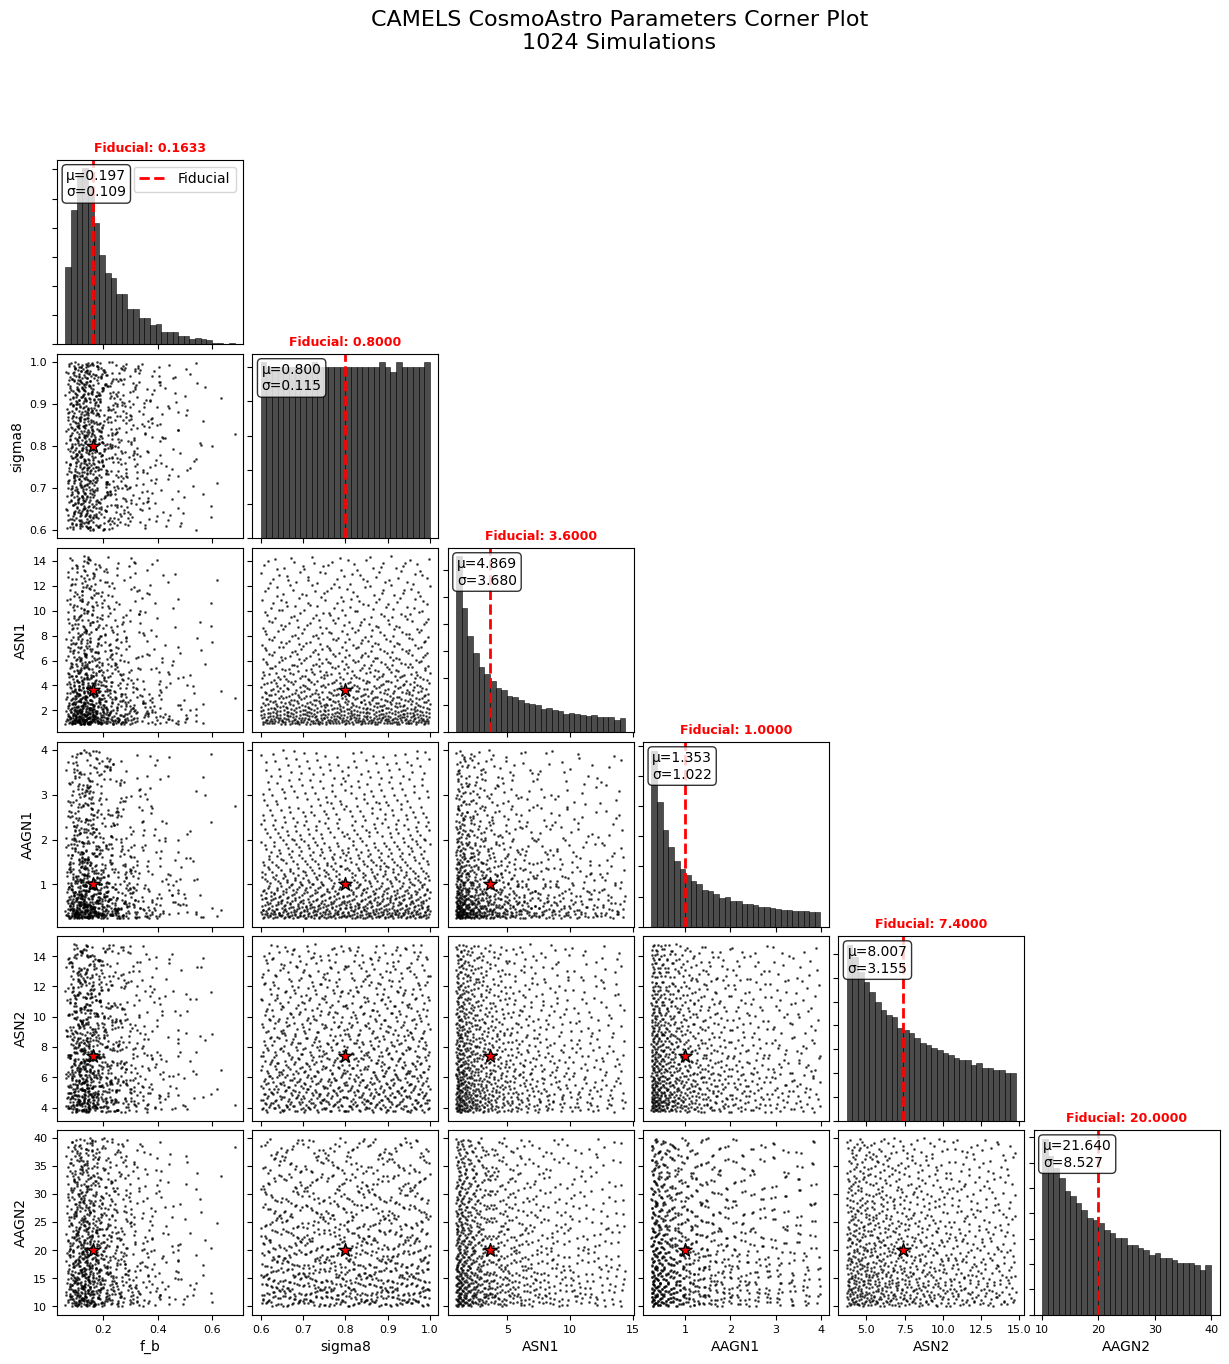

In [134]:
fig_cosmo = plot_camels_corner(new_params_matrix[:,:6],
                               fiducial_values = new_fiducial_values[:6],
                                     param_names=new_cosmo_names,
                                     figsize=(15, 15),
                                     save_path="camels_cosmo_corner_fb_s8_ANG_SN.png")

plt.show()

# Read all sims

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import stats

def read_camels_param_info(csv_filename="SB35_param_minmax.csv"):
    """
    Read parameter names and fiducial values from CSV file.
    
    Parameters:
    -----------
    csv_filename : str
        Path to CSV file with columns A (param_names) and D (fiducial_values)
        
    Returns:
    --------
    param_names : list
        List of parameter names
    fiducial_values : numpy array
        Array of fiducial values
    """
    try:
        # Read CSV file, skipping header
        df = pd.read_csv(csv_filename, header=0)
        
        # Extract column A (param_names) and column D (fiducial_values)
        # Assuming 0-indexed: A=0, B=1, C=2, D=3
        param_names = df.iloc[:, 0].tolist()  # Column A
        fiducial_values = df.iloc[:, 3].values  # Column D
        
        print(f"Read {len(param_names)} parameters from {csv_filename}")
        print(f"First 5 parameters: {param_names[:5]}")
        print(f"First 5 fiducials: {fiducial_values[:5]}")
        
        return param_names, fiducial_values
        
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None, None


In [23]:
def find_fiducial_simulation(params_matrix, fiducial_values, param_names=None, tolerance_multiplier=1.0):
    """
    Find the simulation index that is closest to the fiducial values.
    
    Parameters:
    -----------
    params_matrix : numpy array
        Parameter matrix (n_simulations x n_parameters)
    fiducial_values : numpy array
        Fiducial values for each parameter
    param_names : list, optional
        List of parameter names for printing
    tolerance_multiplier : float
        Multiplier for tolerance (higher = more lenient)
    
    Returns:
    --------
    fiducial_sim_index : int
        Index of simulation closest to fiducial values
    distance : float
        Euclidean distance to fiducial values
    """
    
    n_sims, n_params = params_matrix.shape
    
    # Find simulation with minimum distance
    normalized_diff = (params_matrix[:, :8] - fiducial_values[:8]) / np.std(params_matrix[:, :8], axis=0)
    fiducial_sim_index = np.argmin(np.sum(normalized_diff**2, axis=1))    
    print(f"Found fiducial simulation:")
    print(f"  Simulation index: {fiducial_sim_index}")



    
    return fiducial_sim_index

In [24]:
params_matrix = np.load("camels_params_matrix.npy")
cosmo_names = ['OmegaMatter', 'sigma8', 'ASN1', 'AAGN1', 'ASN2', 'AAGN2', 'OmegaBaryon', 'Hubble parameter']

param_names, fiducial_values = read_camels_param_info("SB35_param_minmax.csv")

fiducial_sim_index = find_fiducial_simulation(params_matrix, fiducial_values, param_names=param_names)

new_params_matrix =  np.column_stack([params_matrix[:,6]/params_matrix[:,0], params_matrix])
new_fiducial_values = np.concatenate([[fiducial_values[6]/fiducial_values[0]], fiducial_values])
new_cosmo_names = np.concatenate([['f_b'],cosmo_names])
f_b = new_params_matrix[:,0]

Read 35 parameters from SB35_param_minmax.csv
First 5 parameters: ['Omega0', 'sigma8', 'WindEnergyIn1e51erg', 'RadioFeedbackFactor', 'VariableWindVelFactor']
First 5 fiducials: [0.3 0.8 3.6 1.  7.4]
Found fiducial simulation:
  Simulation index: 580


Figure saved to camels_cosmo_corner.png


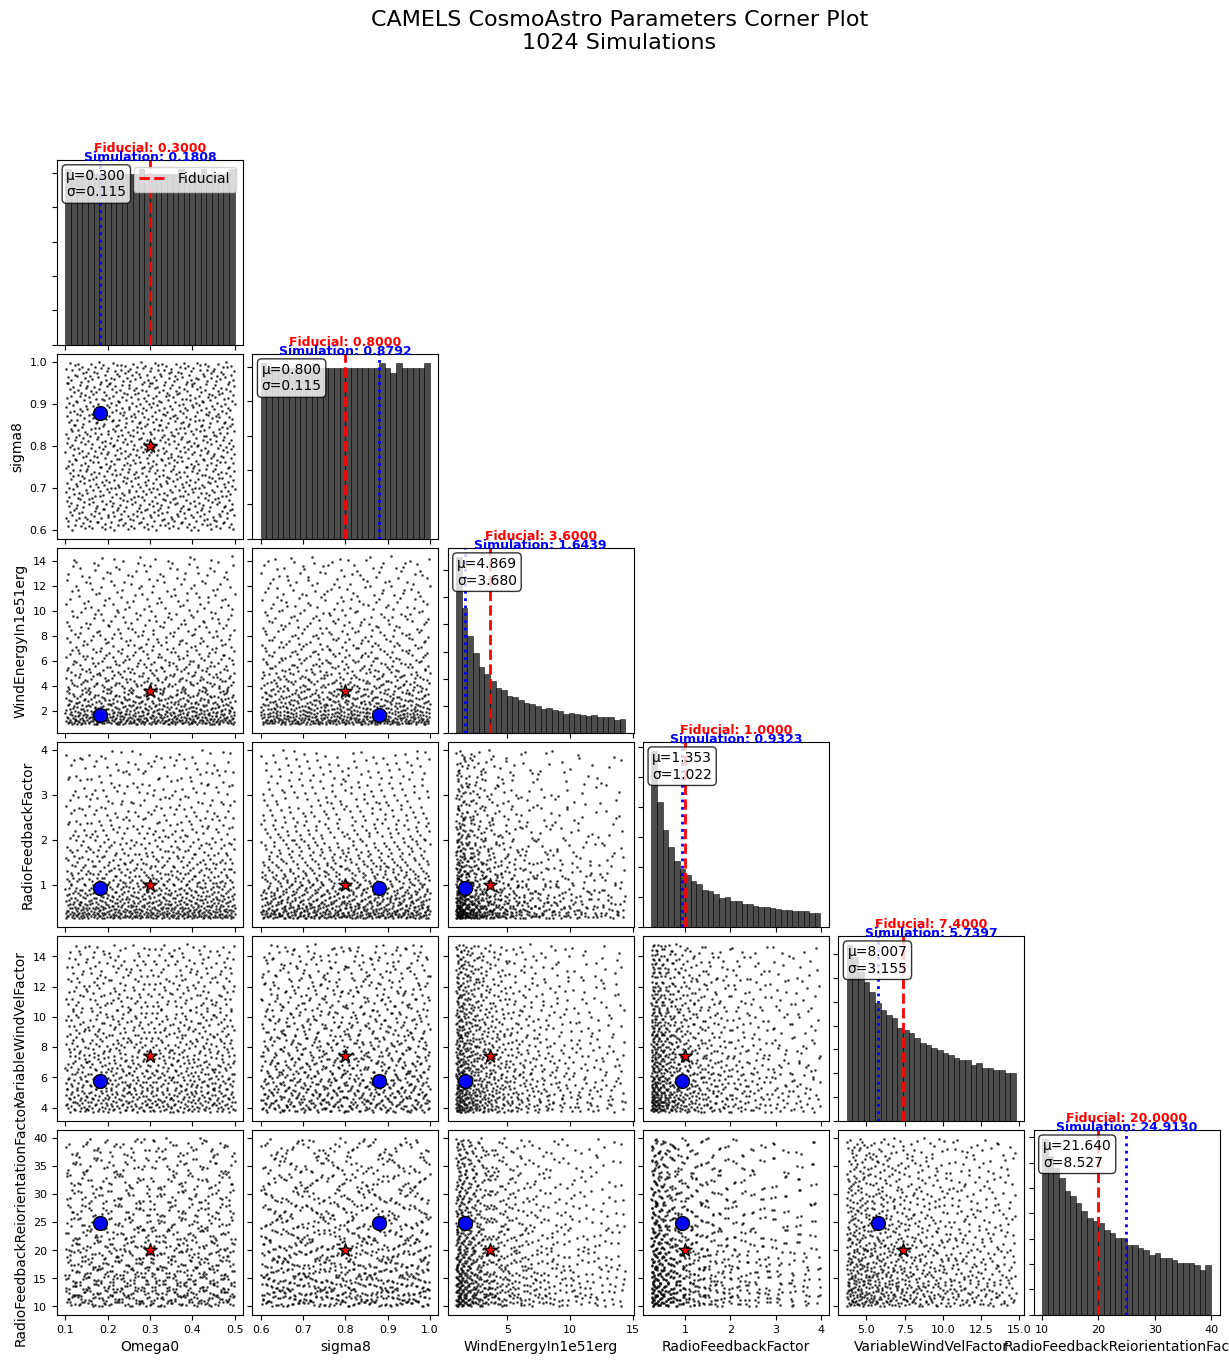

In [29]:
fig_cosmo = plot_camels_corner(params_matrix[:,:6],
                               fiducial_values = fiducial_values[:6],
                                     param_names=param_names,
                                     sim_ind= 158,
                                     figsize=(15, 15),
                                     save_path="camels_cosmo_corner.png")

plt.show()

In [4]:

def sample_parameter_simulations(data, param_names, fiducial_values, target_param_index, n_sample):
    """
    Sample simulations uniformly across one parameter's range while keeping others at fiducial.
    
    Parameters:
    -----------
    data : numpy array
        Parameter matrix (n_simulations x n_parameters)
    param_names : list
        List of parameter names
    fiducial_values : numpy array
        Fiducial values for each parameter
    target_param_index : int
        Index of the parameter to vary (0 to n_parameters-1)
    n_sample : int
        Number of simulations to sample uniformly across target parameter range
        
    Returns:
    --------
    selected_indices : numpy array
        Indices of selected simulations, including min and max values
    """
    
    tolerance_percent = 100
    n_sims, n_params = data.shape
    
    print(f"Sampling {n_sample} simulations varying parameter: {param_names[target_param_index]} (index {target_param_index})")
    
    # Find simulations close to fiducial in all OTHER parameters
    close_to_fiducial = np.ones(n_sims, dtype=bool)
    
    for i in range(n_params):
        if i == target_param_index:
            continue  # Skip the target parameter
            
        param_values = data[:, i]
        fiducial_val = fiducial_values[i]
        
        # Calculate tolerance range

        tolerance = np.std(param_values) * tolerance_percent / 100.0
        
        # Check which simulations are within tolerance
        within_tolerance = np.abs(param_values - fiducial_val) <= tolerance
        close_to_fiducial &= within_tolerance
    
    # Get valid simulation indices
    valid_indices = np.where(close_to_fiducial)[0]
    
    if len(valid_indices) == 0:
        print("No simulations found with other parameters close to fiducial!")
        return np.array([])
    
    print(f"Found {len(valid_indices)} simulations with other parameters within {tolerance_percent}% of sigma from fiducial")
    
    # Get target parameter values for valid simulations
    target_values = data[valid_indices, target_param_index]
    
    # Find min and max indices
    min_idx = valid_indices[np.argmin(target_values)]
    max_idx = valid_indices[np.argmax(target_values)]
    min_val = np.min(target_values)
    max_val = np.max(target_values)

    target_points = np.linspace(min_val, max_val, n_sample)
    selected_indices = []
    
    # Always include min and max
    selected_indices.append(min_idx)
    
    # Find closest simulation for each intermediate target point
    for i in range(1, n_sample - 1):
        target_point = target_points[i]
        distances = np.abs(target_values - target_point)
        closest_idx = valid_indices[np.argmin(distances)]
        
        # Avoid duplicates
        if closest_idx not in selected_indices:
            selected_indices.append(closest_idx)
    
    # Always include max (avoid duplicate if min == max)
    if max_idx not in selected_indices:
        selected_indices.append(max_idx)
    
    selected_indices = np.array(selected_indices)
    # Sort by target parameter value
    target_values_selected = data[selected_indices, target_param_index]
    sorted_order = np.argsort(target_values_selected)
    selected_indices = selected_indices[sorted_order]
    
    # Print summary
    print(f"Selected {len(selected_indices)} simulations:")
    for i, sim_idx in enumerate(selected_indices):
        target_val = data[sim_idx, target_param_index]
        print(f"  Simulation {sim_idx}: {param_names[target_param_index]} = {target_val:.4f}")
    
    print(f"Target parameter range: {min_val:.4f} to {max_val:.4f}")
    print(f"Fiducial value: {fiducial_values[target_param_index]:.4f}")
    
    return selected_indices

In [ ]:
fb_sims = sample_parameter_simulations(new_params_matrix[:,:8],
                               fiducial_values = new_fiducial_values[:8],
                                     param_names=new_cosmo_names,
                             target_param_index=0, 
                             n_sample=500)
h_sims = sample_parameter_simulations(new_params_matrix[:,:9],
                               fiducial_values = new_fiducial_values[:9],
                                     param_names=new_cosmo_names,
                             target_param_index=8, 
                             n_sample=500)
np.save('h_varying_sims.npy',h_sims)
np.save('h_varying_vals.npy',new_params_matrix[h_sims, 8])
Omegab_sims = sample_parameter_simulations(new_params_matrix[:,:8],
                               fiducial_values = new_fiducial_values[:8],
                                     param_names=new_cosmo_names,
                             target_param_index=7, 
                             n_sample=500)
np.save('Omegab_varying_sims.npy',Omegab_sims)
np.save('Omegab_varying_vals.npy',new_params_matrix[Omegab_sims, 7])
AAGN1_sims = sample_parameter_simulations(new_params_matrix[:,:8],
                               fiducial_values = new_fiducial_values[:8],
                                     param_names=new_cosmo_names,
                             target_param_index=4, 
                             n_sample=500)
np.save('AAGN1_varying_sims.npy',AAGN1_sims)
np.save('AAGN1_varying_vals.npy',new_params_matrix[AAGN1_sims, 4])
ASN1_sims = sample_parameter_simulations(new_params_matrix[:,:8],
                               fiducial_values = new_fiducial_values[:8],
                                     param_names=new_cosmo_names,
                             target_param_index=3, 
                             n_sample=500)
np.save('ASN1_varying_sims.npy',ASN1_sims)
np.save('ASN1_varying_vals.npy',new_params_matrix[ASN1_sims, 3])
ASN2_sims = sample_parameter_simulations(new_params_matrix[:,:8],
                               fiducial_values = new_fiducial_values[:8],
                                     param_names=new_cosmo_names,
                             target_param_index=5, 
                             n_sample=500)
np.save('ASN2_varying_sims.npy',ASN2_sims)
np.save('ASN2_varying_vals.npy',new_params_matrix[ASN2_sims, 5])
AAGN2_sims = sample_parameter_simulations(new_params_matrix[:,:8],
                               fiducial_values = new_fiducial_values[:8],
                                     param_names=new_cosmo_names,
                             target_param_index=6, 
                             n_sample=500)

Sampling 500 simulations varying parameter: f_b (index 0)
Found 39 simulations with other parameters within 100% of sigma from fiducial
Selected 39 simulations:
  Simulation 956: f_b = 0.1056
  Simulation 1015: f_b = 0.1084
  Simulation 819: f_b = 0.1102
  Simulation 428: f_b = 0.1181
  Simulation 371: f_b = 0.1224
  Simulation 580: f_b = 0.1275
  Simulation 123: f_b = 0.1308
  Simulation 739: f_b = 0.1308
  Simulation 392: f_b = 0.1313
  Simulation 467: f_b = 0.1327
  Simulation 2: f_b = 0.1331
  Simulation 164: f_b = 0.1339
  Simulation 43: f_b = 0.1389
  Simulation 4: f_b = 0.1452
  Simulation 136: f_b = 0.1489
  Simulation 669: f_b = 0.1495
  Simulation 141: f_b = 0.1504
  Simulation 780: f_b = 0.1507
  Simulation 691: f_b = 0.1570
  Simulation 292: f_b = 0.1572
  Simulation 555: f_b = 0.1581
  Simulation 427: f_b = 0.1644
  Simulation 868: f_b = 0.1661
  Simulation 738: f_b = 0.1685
  Simulation 221: f_b = 0.1713
  Simulation 843: f_b = 0.1776
  Simulation 794: f_b = 0.1789
  Simu

Plotting selected min and max sims for f_b


/tmp/ipykernel_831072/3339172818.py:51: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(r_bins, median, label=name+f' with  {param_name} = {new_params_matrix[SB35_sim_index,target_param_index]:.2f}', c=colours[i])


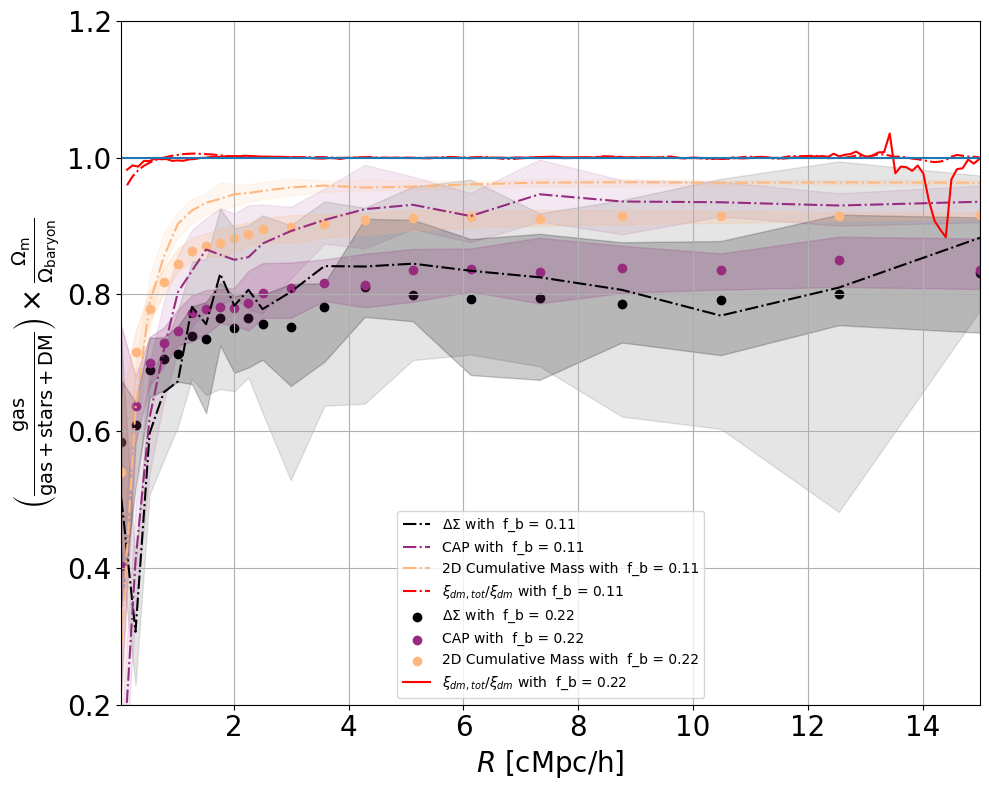

Plotting selected min and max sims for AAGN1


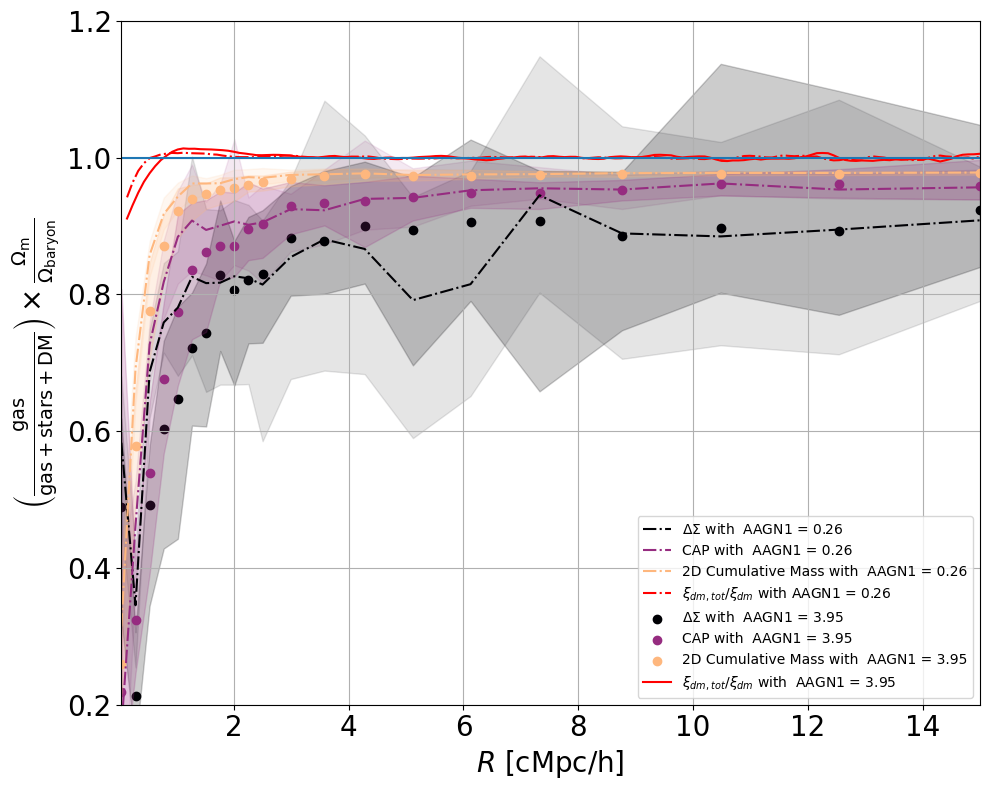

Plotting selected min and max sims for ASN1


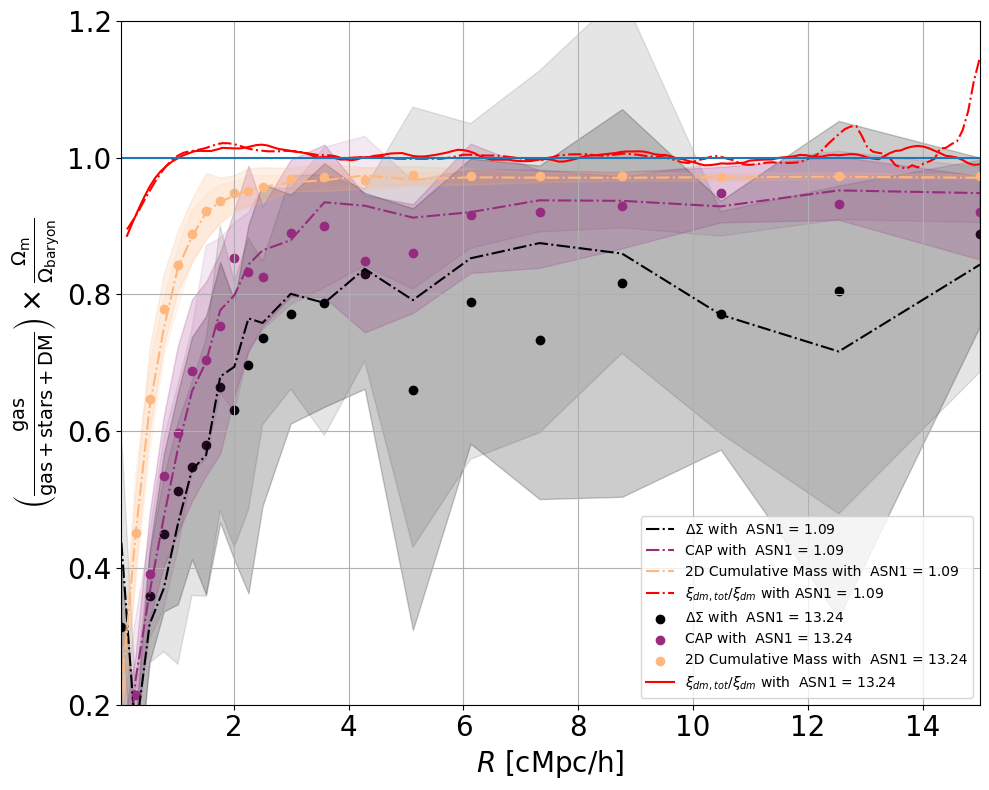

Plotting selected min and max sims for ASN2


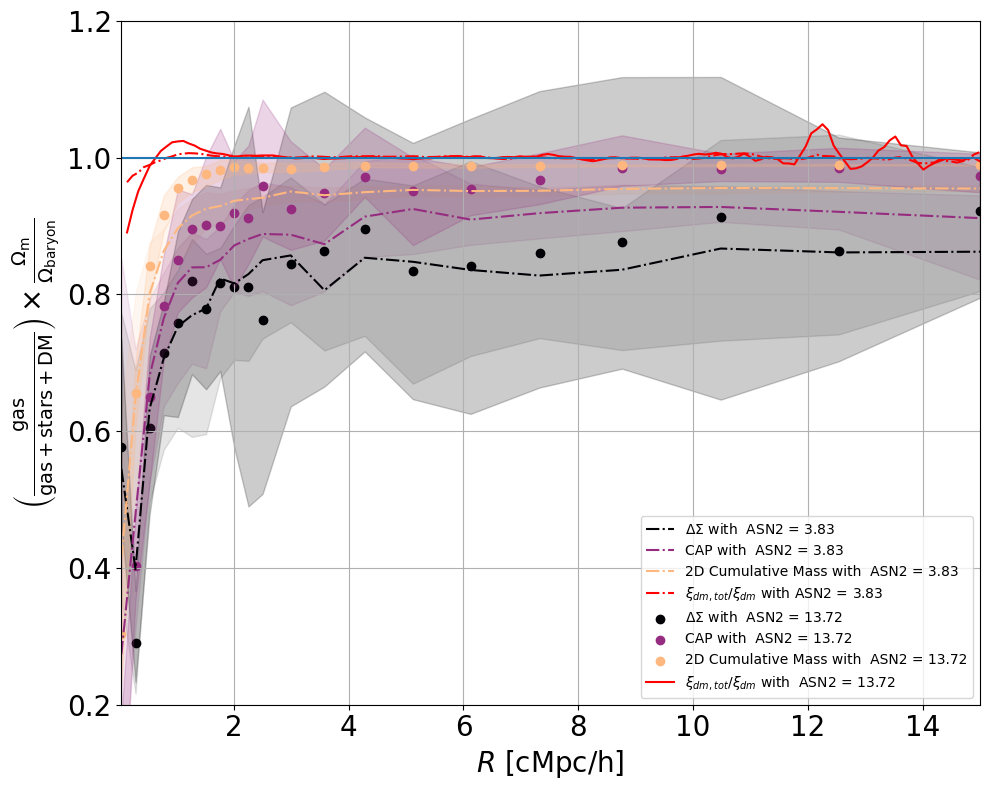

Plotting selected min and max sims for AAGN2


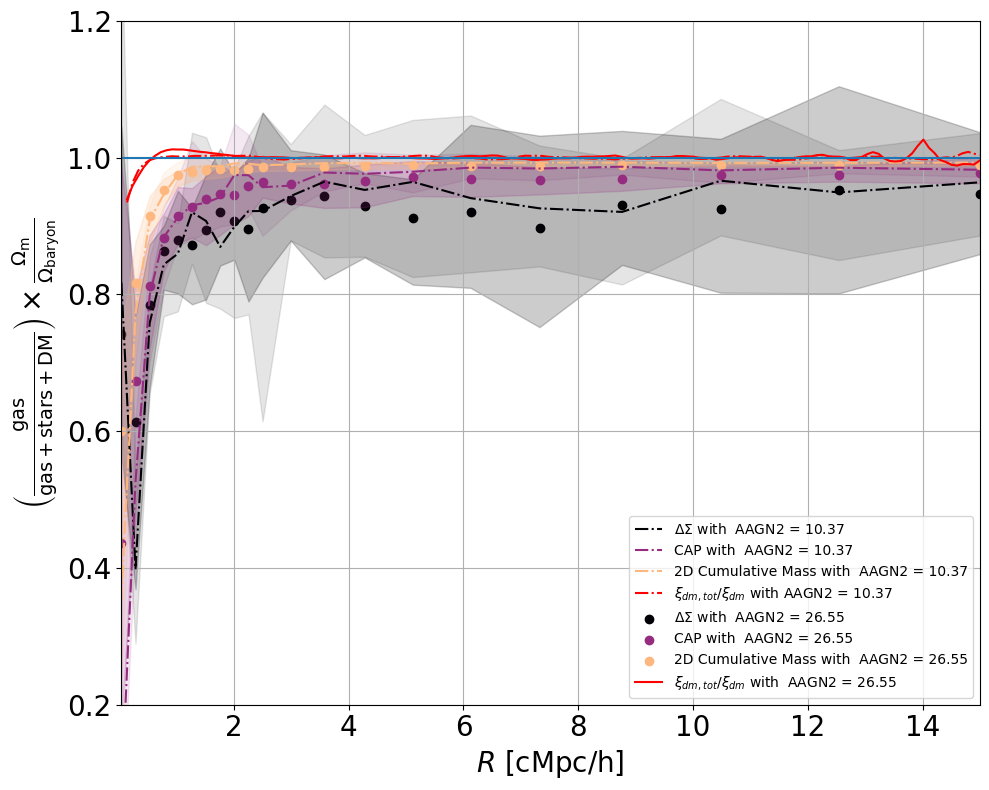

In [8]:
import matplotlib

def plot_param_min_max_profiles(sims_id,target_param_index):

    param_name = new_cosmo_names[target_param_index]
    print(f'Plotting selected min and max sims for {param_name}')
    SB35_sim_index = sims_id[0]
    Henry_profiles_sim =  np.load(f'/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_{SB35_sim_index}/data/'+ f"Henry_profiles_gas_dm_star_bh_nPixel1000_R_lin0.04_2.5_log15_nbins20.npz")
    Henry_profiles_sim_PX = np.load(f'/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_{SB35_sim_index}/data/' + 'baryon_suppression_fields_nPixel512.npz')
    f_b = new_params_matrix[:,0]
    filt_func_names = Henry_profiles_sim['profile_names']
    r_bins =  Henry_profiles_sim['r_bins']
    
    fig = plt.figure(figsize=(10,8))
    colourmap = matplotlib.colormaps['magma']
    colours = colourmap(np.linspace(0, 0.85, 3))
    for i, name in enumerate(filt_func_names):
        profiles_g, profiles_m, profiles_s, profiles_bh = Henry_profiles_sim['profiles'][i]
        gas_fraction = profiles_g / (profiles_g + profiles_m + profiles_s+profiles_bh) / f_b[SB35_sim_index]
        upper = np.quantile(gas_fraction, 0.25, axis=0)
        lower = np.quantile(gas_fraction, 0.75, axis=0)
        mean = np.mean(gas_fraction, axis=0)
        median = np.median(gas_fraction, axis=0)
        plt.fill_between(r_bins, lower, upper, alpha=0.1, color=colours[i])
        plt.plot(r_bins, median, ls='-.', label=name+f' with  {param_name} = {new_params_matrix[SB35_sim_index,target_param_index]:.2f}', c=colours[i])
    
    r = Henry_profiles_sim_PX['r']
    k =  Henry_profiles_sim_PX['k']
    XX =  Henry_profiles_sim_PX['XX_dm_tot']
    X_dm = Henry_profiles_sim_PX['X_dm']
    X_tot =  Henry_profiles_sim_PX['X_tot']
    plt.plot(r[r<=15], (XX/X_dm)[r<=15],ls='-.', label=r'$\xi_{dm,tot}/\xi_{dm}$'+f' with {param_name} = {new_params_matrix[SB35_sim_index,target_param_index]:.2f}', color='r')
    
    
    SB35_sim_index = sims_id[-1]
    Henry_profiles_sim =  np.load(f'/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_{SB35_sim_index}/data/'+ f"Henry_profiles_gas_dm_star_bh_nPixel1000_R_lin0.04_2.5_log15_nbins20.npz")
    Henry_profiles_sim_PX = np.load(f'/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_{SB35_sim_index}/data/' + 'baryon_suppression_fields_nPixel512.npz')
    f_b = new_params_matrix[:,0]
    filt_func_names = Henry_profiles_sim['profile_names']
    r_bins =  Henry_profiles_sim['r_bins']
    colourmap = matplotlib.colormaps['magma']
    colours = colourmap(np.linspace(0, 0.85, 3))
    for i, name in enumerate(filt_func_names):
        profiles_g, profiles_m, profiles_s, profiles_bh = Henry_profiles_sim['profiles'][i]
        gas_fraction = profiles_g / (profiles_g + profiles_m + profiles_s+profiles_bh) / f_b[SB35_sim_index]
        upper = np.quantile(gas_fraction, 0.25, axis=0)
        lower = np.quantile(gas_fraction, 0.75, axis=0)
        mean = np.mean(gas_fraction, axis=0)
        median = np.median(gas_fraction, axis=0)
        plt.fill_between(r_bins, lower, upper, alpha=0.2, color=colours[i])
        plt.scatter(r_bins, median, label=name+f' with  {param_name} = {new_params_matrix[SB35_sim_index,target_param_index]:.2f}', c=colours[i])
    
    r = Henry_profiles_sim_PX['r']
    k =  Henry_profiles_sim_PX['k']
    XX =  Henry_profiles_sim_PX['XX_dm_tot']
    X_dm = Henry_profiles_sim_PX['X_dm']
    X_tot =  Henry_profiles_sim_PX['X_tot']
    plt.plot(r[r<=15], (XX/X_dm)[r<=15], label=r'$\xi_{dm,tot}/\xi_{dm}$'+ f' with  {param_name} = {new_params_matrix[SB35_sim_index,target_param_index]:.2f}', color='r')
    
    plt.axhline(1)
    plt.xlim((r_bins[0], r_bins[-1]))
    plt.xlabel(r'$R$ [cMpc/h]', fontsize=20)
    plt.ylabel(r'$\left(\frac{\rm gas}{\rm gas + stars + DM}\right) \times \frac{\Omega_m}{\Omega_{\rm baryon}}$', fontsize=20)
    
    plt.xticks(fontsize=20)
    plt.ylim((.2, 1.2))
    plt.yticks(fontsize=20)
    plt.legend(fontsize=10)
    #plt.xscale('log')
    plt.grid()
    plt.tight_layout()
    plt.show()
    fig.savefig(f'{param_name}_min_max.png')

plot_param_min_max_profiles(fb_sims,0)
plot_param_min_max_profiles(AAGN1_sims,4)
plot_param_min_max_profiles(ASN1_sims,3)
plot_param_min_max_profiles(ASN2_sims,5)
plot_param_min_max_profiles(AAGN2_sims,6)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

def plot_multi_simulations(SB35_sim_indices, varying_param_values):
    """
    Plot 2 subplots for multiple simulations:
    - Top: XX/X_dm ratios
    - Bottom: Gas fraction profiles with different line styles for different filter functions
    
    Parameters:
    -----------
    SB35_sim_indices : list
        List of simulation indices
    varying_param_values : array-like
        Parameter values corresponding to each simulation (for colorbar)
    """
    
    # Set up colormap
    colourmap = matplotlib.colormaps['viridis']
    colors = colourmap(np.linspace(0, 1, len(SB35_sim_indices)))
    
    # Line styles for different filter functions
    line_styles = ['-', '--', '-.']
    
    # Create figure with 2 subplots in (2,1) layout
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Loop through each simulation
    for sim_idx, (SB35_sim_index, color) in enumerate(zip(SB35_sim_indices, colors)):
        
        # Load data for this simulation
        Henry_profiles_sim = np.load(f'/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_{SB35_sim_index}/data/'
                                   + f"Henry_profiles_gas_dm_star_bh_nPixel1000_R_lin0.04_2.5_log15_nbins20.npz")
        Henry_profiles_sim_PX = np.load(f'/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_{SB35_sim_index}/data/'
                                      + 'baryon_suppression_fields_nPixel512.npz')
        
        # Extract data
        filt_func_names = Henry_profiles_sim['profile_names']
        r_bins = Henry_profiles_sim['r_bins']
        r = Henry_profiles_sim_PX['r']
        XX = Henry_profiles_sim_PX['XX_dm_tot']
        X_dm = Henry_profiles_sim_PX['X_dm']
        
        # Plot 1: XX/X_dm ratios
        mask = r <= 15
        ax1.plot(r[mask], (XX/X_dm)[mask], color=color, 
                label=f'Sim {SB35_sim_index} (f_b={varying_param_values[sim_idx]:.3f})')
        
        # Plot 2: Profiles with different line styles for different filter functions
        for i, name in enumerate(filt_func_names):
            profiles_g, profiles_m, profiles_s, profiles_bh = Henry_profiles_sim['profiles'][i]
            gas_fraction = profiles_g / (profiles_g + profiles_m + profiles_s + profiles_bh) / f_b[SB35_sim_index]
            median = np.median(gas_fraction, axis=0)
            
            # Use different line styles for different filter functions
            linestyle = line_styles[i % len(line_styles)]
            
            # Only add filter function name to label for first simulation to avoid clutter
            if sim_idx == 0:
                label = f'{name}'
            else:
                label = None
                
            ax2.plot(r_bins, median, color=color, linestyle=linestyle, label=label)
    
    # Subplot 1: XX/X_dm
    ax1.axhline(1, color='black', linestyle='-', alpha=0.5)
    ax1.set_xlabel(r'$R$ [cMpc/h]', fontsize=14)
    ax1.set_ylabel(r'$\xi_{dm,tot}/\xi_{dm}$', fontsize=14)
    ax1.grid(True, alpha=0.3)    
    # Subplot 2: Profiles
    ax2.set_xlim((r_bins[0], r_bins[-1]))
    ax2.set_xlabel(r'$R$ [cMpc/h]', fontsize=14)
    ax2.set_ylabel(r'Cumulative Profile Fraction', fontsize=14)
    ax2.set_ylim((0.0, 1.5))
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    sm = plt.cm.ScalarMappable(cmap=colourmap, 
                              norm=plt.Normalize(vmin=min(varying_param_values), 
                                               vmax=max(varying_param_values)))
    sm.set_array([])
    
    # Adjust subplot spacing to make room for colorbar
    plt.subplots_adjust(right=0.85)
    
    # Create colorbar outside the plots
    cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label(r'$\Omega_{\rm baryon}/\Omega_m$', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)

# Example usage:
# SB35_sim_indices = [777, 778, 779]  # List of simulation indices
# varying_param_values = [0.1, 0.2, 0.3]  # Corresponding parameter values
# fig, axes = plot_multi_simulations(SB35_sim_indices, varying_param_values)

In [1]:
import matplotlib
def scatter_plot_multi_simulations(SB35_sim_indices, target_param_index, varying_param_name=r'$\Omega_{\rm baryon}/\Omega_m$'):
    """
    Plot 4 subplots for multiple simulations:
    - Top left: Field-level power suppression PX_dm_tot/P_dm vs k
    - Top right, Bottom left, Bottom right: Scatter plots of PX_dm_tot/P_dm vs gas_fraction for each filter function
    
    Parameters:
    -----------
    SB35_sim_indices : list
        List of simulation indices
    varying_param_values : array-like
        Parameter values corresponding to each simulation (for colorbar)
    varying_param_name : str
        Name for the colorbar label
    """
    varying_param_values = new_params_matrix[SB35_sim_indices, target_param_index]
    print(f'Scatter Plot for {new_cosmo_names[target_param_index]} from {SB35_sim_indices[0]} to {SB35_sim_indices[-1]}')
    
    # Set up colormap
    colourmap = matplotlib.colormaps['viridis']
    colors = colourmap(np.linspace(0, 1, len(SB35_sim_indices)))
    
    # Create figure with 2x2 subplots with shared y-axis
    fig, (ax1, axes_profiles) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    # Axes for the three profile plots
    
    # Dot styles for different R and k combinations
    dot_styles = ['o', 's', '^', 'D']  # circle, square, triangle, diamond
    R_values = [0.4, 4.0]
    k_values = [0.3, 3.0]
    
    # Loop through each simulation
    for sim_idx, (SB35_sim_index, color) in enumerate(zip(SB35_sim_indices, colors)):
        
        # Load data for this simulation
        Henry_profiles_sim = np.load(f'/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_{SB35_sim_index}/data/'
                                   + f"Henry_profiles_gas_dm_star_bh_nPixel1000_R_lin0.04_2.5_log15_nbins20.npz")
        Henry_profiles_sim_PX = np.load(f'/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_{SB35_sim_index}/data/'
                                      + 'baryon_suppression_fields_nPixel512.npz')
        
        # Extract data
        filt_func_names = Henry_profiles_sim['profile_names']
        r_bins = Henry_profiles_sim['r_bins']
        k = Henry_profiles_sim_PX['k']
        PX_dm_tot = Henry_profiles_sim_PX['PX_dm_tot']
        P_dm = Henry_profiles_sim_PX['P_dm']
        P_tot= Henry_profiles_sim_PX['P_tot']
        
        # Plot 1: Field-level power suppression vs k
        mask_k = k <= 10
        ax1.plot(k[mask_k], (PX_dm_tot*np.sqrt(P_tot)/np.sqrt(P_dm))[mask_k], color=color)
        
        name = r'$\rm M_{\rm b}/\rm M_{\rm total}$'
        profiles_g, profiles_m, profiles_s, profiles_bh = Henry_profiles_sim['profiles'][-1]
        gas_fraction = profiles_g / (profiles_g + profiles_m + profiles_s + profiles_bh) / f_b[SB35_sim_index]
        
        # Get gas fraction at R=0.4 and R=4.0
        r_idx_04 = np.argmin(np.abs(r_bins - R_values[0]))
        r_idx_4 = np.argmin(np.abs(r_bins - R_values[-1]))
        gas_frac_04 = np.median(gas_fraction[:, r_idx_04])
        gas_frac_4 = np.median(gas_fraction[:, r_idx_4])
        
        # Get PX_dm_tot/P_dm at k=1 and k=10
        k_idx_1 = np.argmin(np.abs(k - k_values[0]))
        k_idx_10 = np.argmin(np.abs(k - k_values[-1]))
        power_ratio_k1 = (PX_dm_tot*np.sqrt(P_tot)/np.sqrt(P_dm))[k_idx_1]
        power_ratio_k10 = (PX_dm_tot*np.sqrt(P_tot)/np.sqrt(P_dm))[k_idx_10]
        
        # Plot 4 different combinations with different dot styles
        axes_profiles.scatter(gas_frac_04, power_ratio_k1, color=color, 
                               marker=dot_styles[0], s=50, alpha=0.1,
                               label=f'R={R_values[0]}, k={k_values[0]}' if sim_idx == 0 else "")
        axes_profiles.scatter(gas_frac_4, power_ratio_k1, color=color, 
                               marker=dot_styles[0], s=50, alpha=1,
                               label=f'R={R_values[-1]}, k={k_values[0]}' if sim_idx == 0 else "")
        axes_profiles.scatter(gas_frac_4, power_ratio_k10, color=color, 
                               marker=dot_styles[1], s=50, alpha=0.1,
                               label=f'R={R_values[-1]}, k={k_values[-1]}' if sim_idx == 0 else "")
        axes_profiles.scatter(gas_frac_04, power_ratio_k10, color=color, 
                               marker=dot_styles[1], s=50, alpha=1,
                                   label=f'R={R_values[0]}, k={k_values[-1]}' if sim_idx == 0 else "")

    
    # Subplot 1: Power suppression vs k
    ax1.set_xlabel(r'$k$ [h/cMpc]', fontsize=12)
    ax1.set_ylabel(r'$P_{dm,tot}/P_{dm}$', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Field-level Power Suppression')
    

    axes_profiles.set_xlabel(f'{name}', fontsize=12)

    axes_profiles.grid(True, alpha=0.3)
    axes_profiles.legend(fontsize=8, loc='best')
    
    # Create colorbar spanning all subplots outside the plots
    sm = plt.cm.ScalarMappable(cmap=colourmap, 
                              norm=plt.Normalize(vmin=min(varying_param_values), 
                                               vmax=max(varying_param_values)))
    sm.set_array([])
    plt.tight_layout()
    # Adjust subplot spacing to make room for colorbar
    plt.subplots_adjust(right=0.85)
    
    # Create colorbar outside the plots
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label(varying_param_name, fontsize=12)
   
    
    plt.show()
    fig.savefig(f'{new_cosmo_names[target_param_index]}_varying_scatter_plot_2_plots.png')
    
    return fig, (ax1, axes_profiles)

Scatter Plot for AAGN2 from 76 to 757


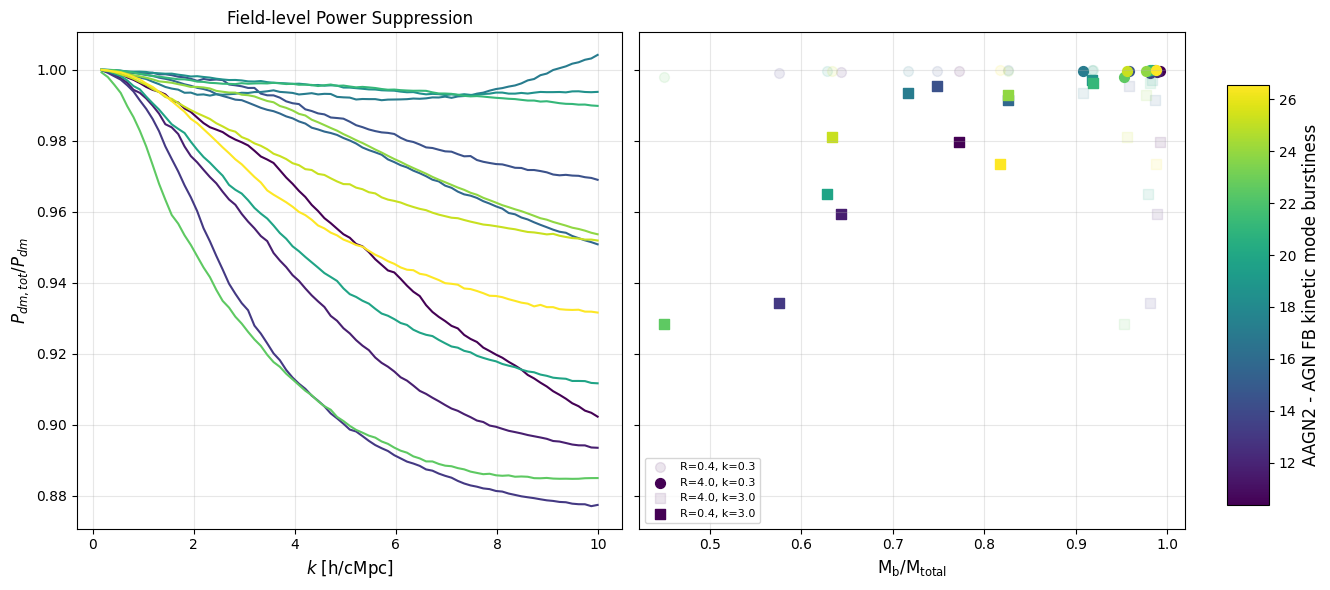

Scatter Plot for f_b from 819 to 21


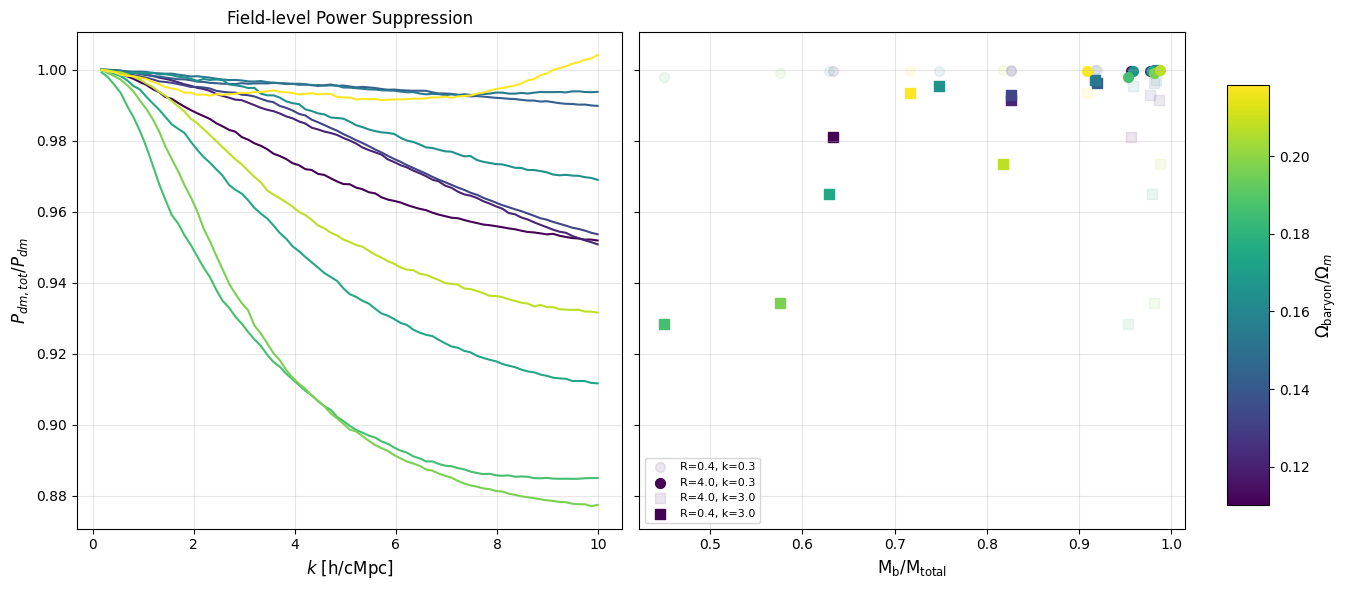

Scatter Plot for AAGN1 from 331 to 506


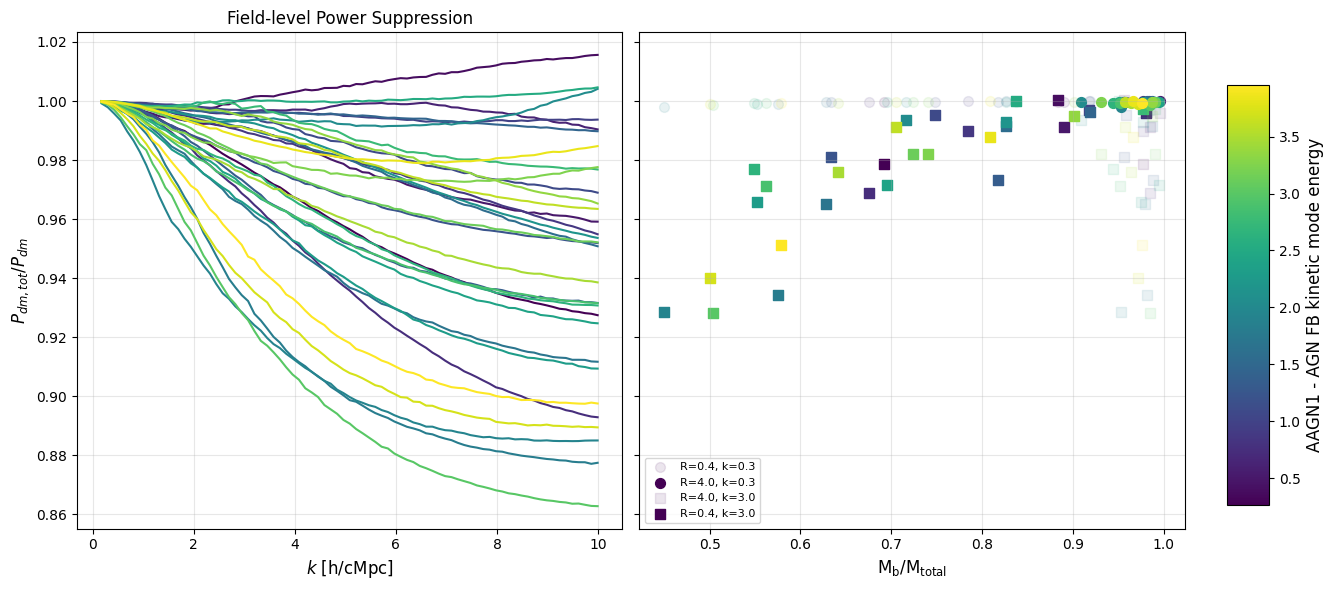

Scatter Plot for ASN1 from 372 to 178


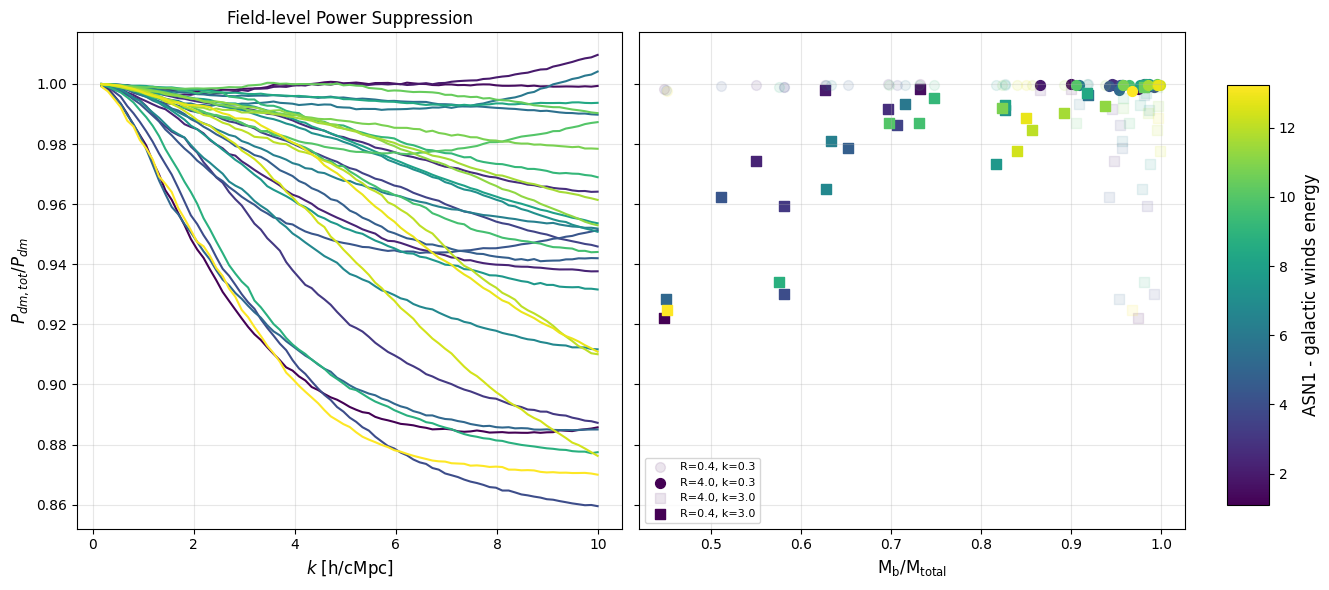

Scatter Plot for ASN2 from 452 to 699


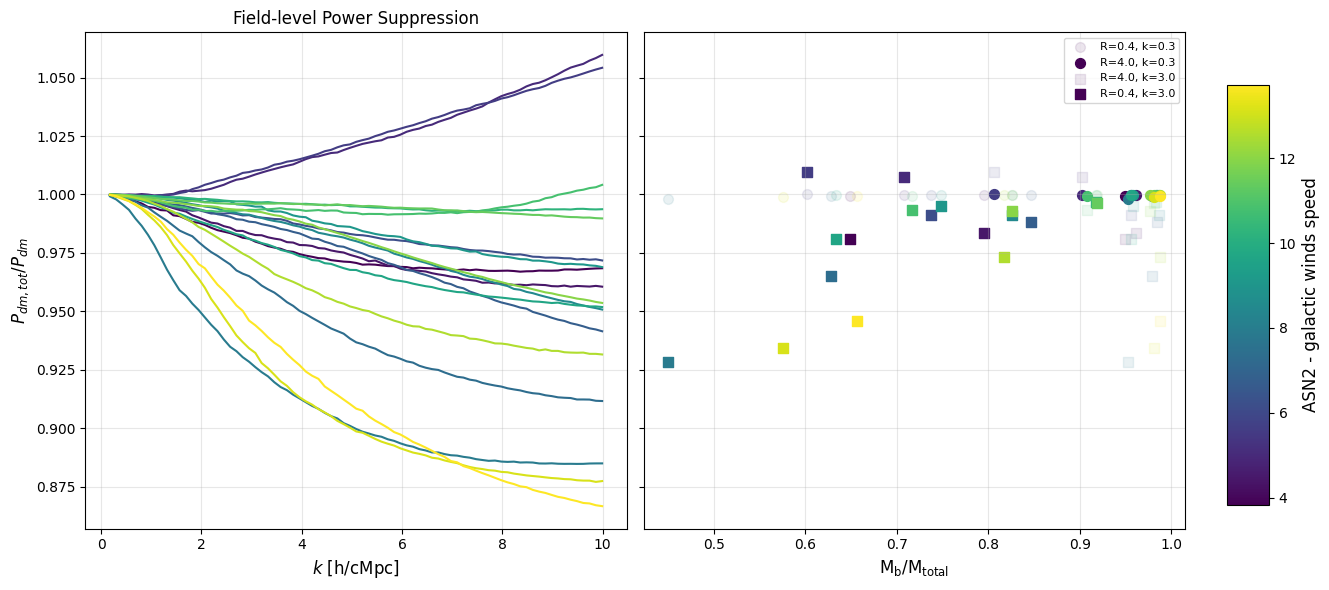

(<Figure size 1400x600 with 3 Axes>,
 (<Axes: title={'center': 'Field-level Power Suppression'}, xlabel='$k$ [h/cMpc]', ylabel='$P_{dm,tot}/P_{dm}$'>,
  <Axes: xlabel='$\\rm M_{\\rm b}/\\rm M_{\\rm total}$'>))

In [ ]:
scatter_plot_multi_simulations(AAGN2_sims,6, varying_param_name=r'AAGN2 - AGN FB kinetic mode burstiness')
scatter_plot_multi_simulations(fb_sims,0, varying_param_name=r'$\Omega_{\rm baryon}/\Omega_m$')
scatter_plot_multi_simulations(AAGN1_sims,4, varying_param_name='AAGN1 - AGN FB kinetic mode energy')
scatter_plot_multi_simulations(ASN1_sims,3, varying_param_name='ASN1 - galactic winds energy')
scatter_plot_multi_simulations(ASN2_sims,5, varying_param_name='ASN2 - galactic winds speed')


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

param_names, fiducial_values = read_camels_param_info("SB35_param_minmax.csv")
theta = np.linspace(1, 6, 9)

def plot_correlation_ksz_param():
    data = np.load('ksz_profiles_sims.npy')
    parameters = np.load('camels_params_matrix.npy')
    # Convert to DataFrames for easier handling
    df_data = pd.DataFrame(data, columns=[f'feature_{i}' for i in range(data.shape[-1])])
    df_params = pd.DataFrame(parameters, columns=[f'param_{i}' for i in range(parameters.shape[-1])])
    
    # Combine datasets
    combined_df = pd.concat([df_data, df_params], axis=1)
    
    # Calculate correlation matrix
    correlation_matrix = combined_df.corr()
    
    # Extract correlations between parameters and features
    param_feature_corr = correlation_matrix.loc[df_params.columns, df_data.columns]

    # Heatmap of correlations
    plt.figure(figsize=(12, 8))
    sns.heatmap(param_feature_corr, annot=True, cmap='coolwarm', center=0,
                xticklabels=[f'{theta[i]}' for i in range(data.shape[-1])],
                yticklabels=[f'{param_names[i]}' for i in range(parameters.shape[-1])])
    plt.title('Correlation between parameters and ksz temperature')
    plt.savefig('correlation_matrix_temp_ksz_params.png')
    plt.show()

Read 35 parameters from SB35_param_minmax.csv
First 5 parameters: ['Omega0', 'sigma8', 'WindEnergyIn1e51erg', 'RadioFeedbackFactor', 'VariableWindVelFactor']
First 5 fiducials: [0.3 0.8 3.6 1.  7.4]


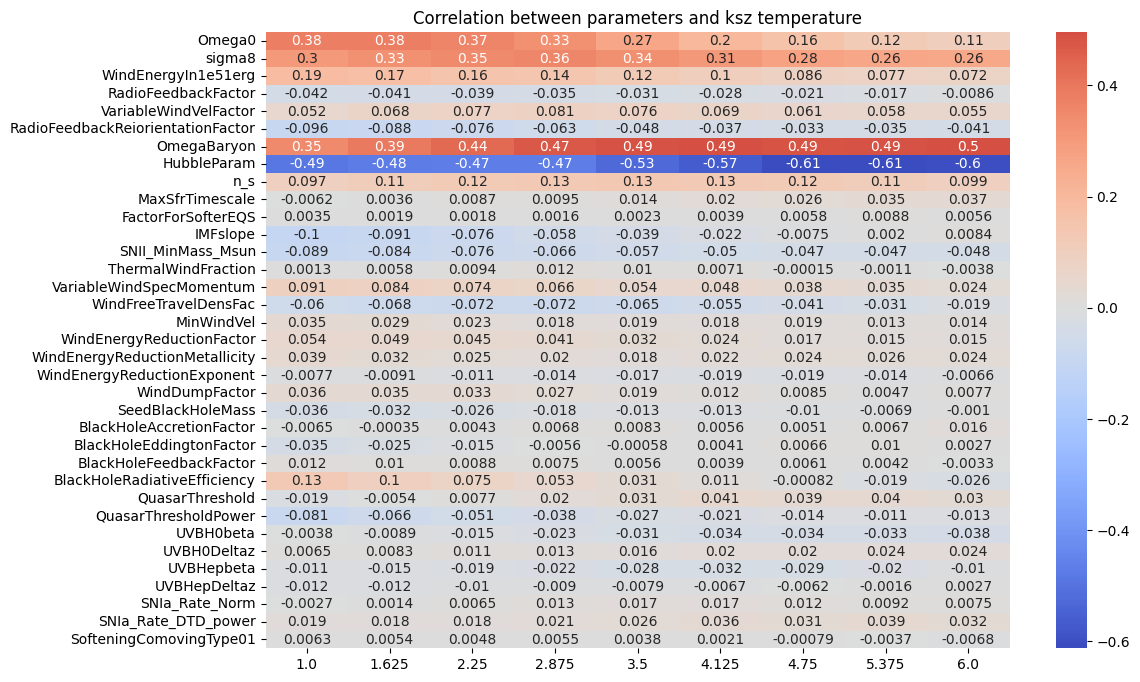

In [29]:
plot_correlation_ksz_param()